# Data Exploration

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
march_df = pd.read_csv("BTC_60min_ETH_60min_march.csv")
april_df = pd.read_csv("BTC_60min_ETH_60min_april.csv")
df = pd.concat([march_df, april_df], axis=0)


C:\Users\Darko\AppData\Local\Temp/ipykernel_8820/661017192.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax2.set_xticks([])


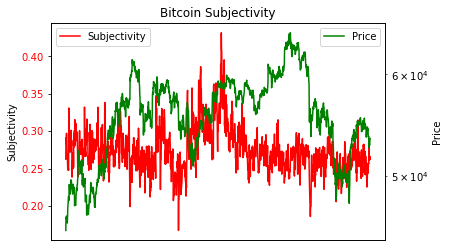

In [70]:

fig, ax = plt.subplots()

# Plot linear sequence, and set tick labels to the same color
ax.plot(df['Timestamp'],df['BTC Subjectivity'], color='red', label = 'Subjectivity')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel("Subjectivity")

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(df['Timestamp'],df['BTC Price'], color='green', label = 'Price')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='green')

ax2.set_xticks([])
ax2.set_xlabel('Date')
ax2.set_ylabel("Price")
plt.title('Bitcoin Subjectivity')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

## MODEL 1: ALL FEATURES

In [71]:
%reset -f

In [72]:
# imports

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [73]:
# read data

march_df = pd.read_csv("BTC_60min_ETH_60min_march.csv")
april_df = pd.read_csv("BTC_60min_ETH_60min_april.csv")

In [74]:
# combine data

df = pd.concat([march_df, april_df], axis=0)

# split testing and training data

train_size = int(np.round(df.shape[0]*0.90))
test_size = int(np.round(df.shape[0]*0.10))

training_set = df.iloc[:train_size, 1:]
test_set = df.iloc[test_size:, 1:]

In [75]:
training_set.head()

,BTC Polarity,BTC Subjectivity,BTC Price,BTC Volume USD,ETH Polarity,ETH Subjectivity,ETH Price,ETH Volume USD,Net Polarity,Net Subjectivity,Net Volume,Price Ratio
0,0.072778,0.262517,45346.19,11649.92686,0.055392,0.318175,1428.53,40722.935570,0.017387,-0.055658,-29073.008710,0.031503
1,0.085035,0.291365,46412.76,559411.14580,0.066055,0.316459,1449.05,47346.094280,0.018980,-0.025094,512065.051520,0.031221
2,0.082575,0.283109,46315.34,133398.27780,0.057733,0.320844,1446.20,17704.424220,0.024842,-0.037735,115693.853580,0.031225
3,0.085187,0.297120,46523.77,214518.75730,0.051403,0.310947,1444.53,32373.785930,0.033785,-0.013827,182144.971370,0.031049
4,0.093412,0.295634,46486.91,144155.18740,0.082866,0.343500,1441.56,6853.752864,0.010546,-0.047867,137301.434536,0.031010


In [76]:
test_set.head()

,BTC Polarity,BTC Subjectivity,BTC Price,BTC Volume USD,ETH Polarity,ETH Subjectivity,ETH Price,ETH Volume USD,Net Polarity,Net Subjectivity,Net Volume,Price Ratio
142,0.086316,0.285444,48678.81,168693.683200,0.074163,0.351459,1648.08,9589.41085,0.012153,-0.066015,159104.272350,0.033856
143,0.089906,0.287892,49008.91,24201.143760,0.060722,0.321168,1667.83,12885.70518,0.029184,-0.033276,11315.438580,0.034031
144,0.101695,0.285272,49007.57,7111.101813,0.053170,0.312276,1654.47,56095.56685,0.048525,-0.027004,-48984.465037,0.033759
145,0.109764,0.310996,49400.00,988925.171100,0.095942,0.365177,1676.52,82445.74561,0.013822,-0.054181,906479.425490,0.033938
146,0.104069,0.289091,49190.24,1460.152262,0.084375,0.344000,1647.16,37120.28358,0.019694,-0.054909,-35660.131318,0.033486


In [77]:
# feature scaling

x_sc = MinMaxScaler(feature_range = (0, 1))
y_sc = MinMaxScaler(feature_range = (0, 1))

training_set.iloc[:, 0:11] = x_sc.fit_transform(training_set.iloc[:, 0:11])
training_set['Price Ratio'] = y_sc.fit_transform(training_set['Price Ratio'].values.reshape(-1,1))
training_set_scaled = training_set.values

In [78]:
# creating a data structure with 6 time-steps and 1 output
window = 6

X_train = []
y_train = []
for i in range(window, train_size):
    X_train.append(training_set_scaled[i-window:i, 0:11])
    y_train.append(training_set_scaled[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 11))

In [79]:
X_train.shape

(1268, 6, 11)

In [80]:
y_train.shape

(1268,)

In [81]:
from keras.layers import Dense, SimpleRNN

# model

model_1 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model_1.add(SimpleRNN(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model_1.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model_1.add(SimpleRNN(units = 50, return_sequences = True))
model_1.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_1.add(SimpleRNN(units = 50, return_sequences = True))
model_1.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation
model_1.add(SimpleRNN(units = 50))
model_1.add(Dropout(0.2))

# Adding the output layer
model_1.add(Dense(units = 1))

# Compiling the RNN
model_1.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [82]:
# Fitting the RNN to the Training set

history_1 = model_1.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
40/40 [==============================] - 5s 12ms/step - loss: 0.3406
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2213
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.1538
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1091
Epoch 5/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0838
Epoch 6/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0708
Epoch 7/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0603
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0498
Epoch 9/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0493
Epoch 10/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0409
Epoch 11/100
40/40 [==============================] - 1s 12ms/step - loss: 0.0370
Epoch 12/100
40/40 [==============================] - 1s 12ms/step - loss: 0.0316
Epoch 13/100
40/40 [=======

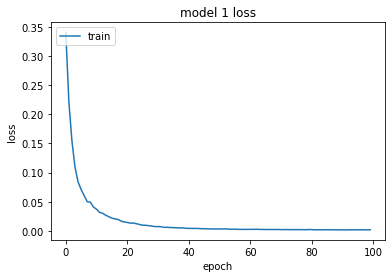

In [83]:
plt.plot(history_1.history['loss'])
#plt.plot(history_1.history['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [84]:
# prep inputs to get predictions

dataset_train = df.iloc[:train_size, 1:]
dataset_test = df.iloc[train_size:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

dataset_total.iloc[:, 0:11] = x_sc.fit_transform(dataset_total.iloc[:, 0:11])
dataset_total['Price Ratio'] = y_sc.fit_transform(dataset_total['Price Ratio'].values.reshape(-1,1))

inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values
inputs = inputs.reshape(-1,12)

X_test = []
for i in range(window, test_size+window):
    X_test.append(inputs[i-window:i, 0:11])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 11))

# get predictions

predicted_values = model_1.predict(X_test)
predicted_values = y_sc.inverse_transform(predicted_values)

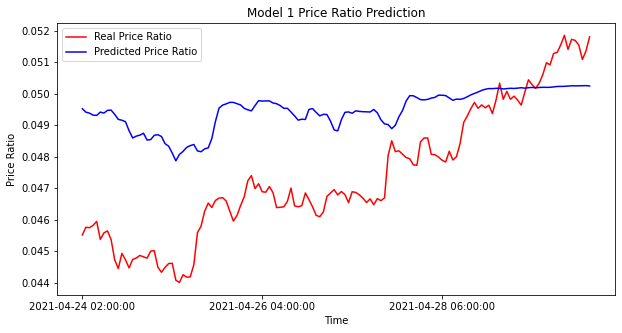

In [85]:
# visualising the results

plt.figure(figsize=(10, 5))
plt.plot(df.iloc[train_size:, 0], dataset_test['Price Ratio'].values, color = 'red', label = 'Real Price Ratio')
plt.plot(df.iloc[train_size:, 0], predicted_values, color = 'blue', label = 'Predicted Price Ratio')
plt.xticks(np.arange(0,test_size,50))
plt.title('Model 1 Price Ratio Prediction')
plt.xlabel('Time')
plt.ylabel('Price Ratio')
plt.legend()

plt.show()

In [86]:
# rmse

rmse = mean_squared_error(dataset_test['Price Ratio'].values, predicted_values, squared=False)
print(rmse)

0.002633354908316203


In [87]:
# std

test_std = np.std(dataset_test['Price Ratio'].values)
print(test_std)

0.002086625168484878


## MODEL 2: ONLY SENTIMENT DATA

In [88]:
%reset -f

In [89]:
# imports

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [90]:
# read data

march_df = pd.read_csv("BTC_60min_ETH_60min_march.csv")
april_df = pd.read_csv("BTC_60min_ETH_60min_april.csv")

In [91]:
# combine data

df = pd.concat([march_df, april_df], axis=0)

df = df[["Timestamp", "BTC Polarity", "ETH Polarity", "BTC Subjectivity", "ETH Subjectivity", "Net Polarity", "Net Subjectivity", "Price Ratio"]]

# split testing and training data

train_size = int(np.round(df.shape[0]*0.90))
test_size = int(np.round(df.shape[0]*0.10))

training_set = df.iloc[:train_size, 1:]
test_set = df.iloc[test_size:, 1:]

In [92]:
training_set.head()

,BTC Polarity,ETH Polarity,BTC Subjectivity,ETH Subjectivity,Net Polarity,Net Subjectivity,Price Ratio
0,0.072778,0.055392,0.262517,0.318175,0.017387,-0.055658,0.031503
1,0.085035,0.066055,0.291365,0.316459,0.018980,-0.025094,0.031221
2,0.082575,0.057733,0.283109,0.320844,0.024842,-0.037735,0.031225
3,0.085187,0.051403,0.297120,0.310947,0.033785,-0.013827,0.031049
4,0.093412,0.082866,0.295634,0.343500,0.010546,-0.047867,0.031010


In [93]:
test_set.head()

,BTC Polarity,ETH Polarity,BTC Subjectivity,ETH Subjectivity,Net Polarity,Net Subjectivity,Price Ratio
142,0.086316,0.074163,0.285444,0.351459,0.012153,-0.066015,0.033856
143,0.089906,0.060722,0.287892,0.321168,0.029184,-0.033276,0.034031
144,0.101695,0.053170,0.285272,0.312276,0.048525,-0.027004,0.033759
145,0.109764,0.095942,0.310996,0.365177,0.013822,-0.054181,0.033938
146,0.104069,0.084375,0.289091,0.344000,0.019694,-0.054909,0.033486


In [94]:
# feature scaling

x_sc = MinMaxScaler(feature_range = (0, 1))
y_sc = MinMaxScaler(feature_range = (0, 1))

training_set.iloc[:, 0:6] = x_sc.fit_transform(training_set.iloc[:, 0:6])
training_set['Price Ratio'] = y_sc.fit_transform(training_set['Price Ratio'].values.reshape(-1,1))
training_set_scaled = training_set.values

In [95]:
# creating a data structure with 6 time-steps and 1 output

window = 6

X_train = []
y_train = []
for i in range(window, train_size):
    X_train.append(training_set_scaled[i-window:i, 0:6])
    y_train.append(training_set_scaled[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))

In [96]:
X_train.shape

(1268, 6, 6)

In [97]:
y_train.shape

(1268,)

In [98]:
# model

model_2 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model_2.add(SimpleRNN(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model_2.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model_2.add(SimpleRNN(units = 50, return_sequences = True))
model_2.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_2.add(SimpleRNN(units = 50, return_sequences = True))
model_2.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_2.add(SimpleRNN(units = 50))
model_2.add(Dropout(0.2))

# Adding the output layer
model_2.add(Dense(units = 1))

# Compiling the RNN
model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [99]:
# Fitting the RNN to the Training set

history_2 = model_2.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
40/40 [==============================] - 4s 9ms/step - loss: 0.3486
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2238
Epoch 3/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1692
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1472
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1254
Epoch 6/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0999
Epoch 7/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1049
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0916
Epoch 9/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0782
Epoch 10/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0796
Epoch 11/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0762
Epoch 12/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0707
Epoch 13/100
40/40 [================

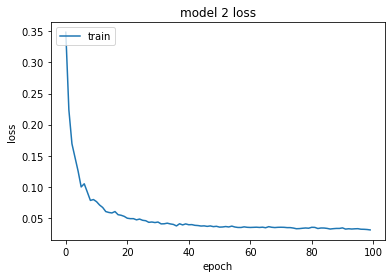

In [100]:
plt.plot(history_2.history['loss'])
#plt.plot(history_2.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [101]:
# prep inputs to get predictions

dataset_train = df.iloc[:train_size, 1:]
dataset_test = df.iloc[train_size:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

dataset_total.iloc[:, 0:6] = x_sc.fit_transform(dataset_total.iloc[:, 0:6])
dataset_total['Price Ratio'] = y_sc.fit_transform(dataset_total['Price Ratio'].values.reshape(-1,1))

inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values
inputs = inputs.reshape(-1,7)

X_test = []
for i in range(window, test_size+window):
    X_test.append(inputs[i-window:i, 0:6])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

# get predictions

predicted_values = model_2.predict(X_test)
predicted_values = y_sc.inverse_transform(predicted_values)

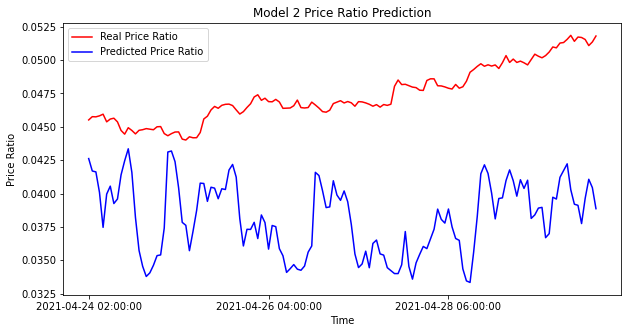

In [102]:
# visualising the results

plt.figure(figsize=(10, 5))
plt.plot(df.iloc[train_size:, 0], dataset_test['Price Ratio'].values, color = 'red', label = 'Real Price Ratio')
plt.plot(df.iloc[train_size:, 0], predicted_values, color = 'blue', label = 'Predicted Price Ratio')
plt.xticks(np.arange(0,test_size,50))
plt.title('Model 2 Price Ratio Prediction')
plt.xlabel('Time')
plt.ylabel('Price Ratio')
plt.legend()

plt.show()

In [103]:
# rmse

rmse = mean_squared_error(dataset_test['Price Ratio'].values, predicted_values, squared=False)
print(rmse)

0.009763105756507795


In [104]:
# std

test_std = np.std(dataset_test['Price Ratio'].values)
print(test_std)

0.002086625168484878


## MODEL 3: ONLY FINANCIAL DATA

In [105]:
%reset -f

In [106]:
# imports

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [107]:
# read data

march_df = pd.read_csv("BTC_60min_ETH_60min_march.csv")
april_df = pd.read_csv("BTC_60min_ETH_60min_april.csv")

In [108]:
# combine data

df = pd.concat([march_df, april_df], axis=0)

df = df[["Timestamp", "BTC Price", "ETH Price", "BTC Volume USD", "ETH Volume USD", "Net Volume", "Price Ratio"]]

# split testing and training data

train_size = int(np.round(df.shape[0]*0.90))
test_size = int(np.round(df.shape[0]*0.10))

training_set = df.iloc[:train_size, 1:]
test_set = df.iloc[test_size:, 1:]

In [109]:
training_set.head()

,BTC Price,ETH Price,BTC Volume USD,ETH Volume USD,Net Volume,Price Ratio
0,45346.19,1428.53,11649.92686,40722.935570,-29073.008710,0.031503
1,46412.76,1449.05,559411.14580,47346.094280,512065.051520,0.031221
2,46315.34,1446.20,133398.27780,17704.424220,115693.853580,0.031225
3,46523.77,1444.53,214518.75730,32373.785930,182144.971370,0.031049
4,46486.91,1441.56,144155.18740,6853.752864,137301.434536,0.031010


In [110]:
test_set.head()

,BTC Price,ETH Price,BTC Volume USD,ETH Volume USD,Net Volume,Price Ratio
142,48678.81,1648.08,168693.683200,9589.41085,159104.272350,0.033856
143,49008.91,1667.83,24201.143760,12885.70518,11315.438580,0.034031
144,49007.57,1654.47,7111.101813,56095.56685,-48984.465037,0.033759
145,49400.00,1676.52,988925.171100,82445.74561,906479.425490,0.033938
146,49190.24,1647.16,1460.152262,37120.28358,-35660.131318,0.033486


In [111]:
# feature scaling

x_sc = MinMaxScaler(feature_range = (0, 1))
y_sc = MinMaxScaler(feature_range = (0, 1))

training_set.iloc[:, 0:5] = x_sc.fit_transform(training_set.iloc[:, 0:5])
training_set['Price Ratio'] = y_sc.fit_transform(training_set['Price Ratio'].values.reshape(-1,1))
training_set_scaled = training_set.values

In [112]:
# creating a data structure with 6 time-steps and 1 output

window = 6

X_train = []
y_train = []
for i in range(window, train_size):
    X_train.append(training_set_scaled[i-window:i, 0:5])
    y_train.append(training_set_scaled[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))

In [113]:
X_train.shape

(1268, 6, 5)

In [114]:
y_train.shape

(1268,)

In [115]:
# model

model_3 = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model_3.add(SimpleRNN(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model_3.add(SimpleRNN(units = 50, return_sequences = True))
model_3.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_3.add(SimpleRNN(units = 50, return_sequences = True))
model_3.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_3.add(SimpleRNN(units = 50))
model_3.add(Dropout(0.2))

# Adding the output layer
model_3.add(Dense(units = 1))

# Compiling the RNN
model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [116]:
# Fitting the RNN to the Training set

history_3 = model_3.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
40/40 [==============================] - 4s 9ms/step - loss: 0.3958
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - loss: 0.2309
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.1287
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.1133
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0929
Epoch 6/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0653
Epoch 7/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0602
Epoch 8/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0503
Epoch 9/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0460
Epoch 10/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0386
Epoch 11/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0323
Epoch 12/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0290
Epoch 13/100
40/40 [==============

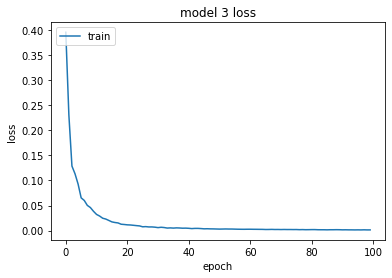

In [117]:
plt.plot(history_3.history['loss'])
#plt.plot(history_3.history['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [118]:
# prep inputs to get predictions

dataset_train = df.iloc[:train_size, 1:]
dataset_test = df.iloc[train_size:, 1:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

dataset_total.iloc[:, 0:5] = x_sc.fit_transform(dataset_total.iloc[:, 0:5])
dataset_total['Price Ratio'] = y_sc.fit_transform(dataset_total['Price Ratio'].values.reshape(-1,1))

inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values
inputs = inputs.reshape(-1,6)

X_test = []
for i in range(window, test_size+window):
    X_test.append(inputs[i-window:i, 0:5])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

# get predictions

predicted_values = model_3.predict(X_test)
predicted_values = y_sc.inverse_transform(predicted_values)

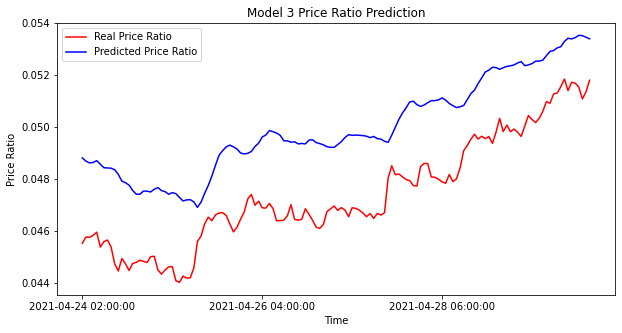

In [119]:
# visualising the results

plt.figure(figsize=(10, 5))
plt.plot(df.iloc[train_size:, 0], dataset_test['Price Ratio'].values, color = 'red', label = 'Real Price Ratio')
plt.plot(df.iloc[train_size:, 0], predicted_values, color = 'blue', label = 'Predicted Price Ratio')
plt.xticks(np.arange(0,test_size,50))
plt.title('Model 3 Price Ratio Prediction')
plt.xlabel('Time')
plt.ylabel('Price Ratio')
plt.legend()

plt.show()

In [120]:
# rmse

rmse = mean_squared_error(dataset_test['Price Ratio'].values, predicted_values, squared=False)
print(rmse)

0.0026208688439806737


In [121]:
# std

test_std = np.std(dataset_test['Price Ratio'].values)
print(test_std)

0.002086625168484878
